<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">

# Accelerating Data Science and Leveraging Foundation Models in Digital Biology  

Copyright (c) 2025, NVIDIA CORPORATION. Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License athttp://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Part 1: Single Cell Data Processing ##

**Table of Contents**
<br>
This notebook shows how to perform single-cell data preprocessing for downstream analysis. This involves filtering, normalizing, and preparing the data for machine learning tasks such as embedding generation and label transfer. This notebook covers the below sections: 

1. [Single Cell Data Processing](#Single-Cell-Data-Processing)
    * [Exploring the dataset](#Exploring-the-dataset)
    * [Calculating QC metrics](#Calculating-QC-metrics)
    * [Filtering low quality cells](#Filtering-low-quality-cells)
    * [Normalization](#Normalization)
    * [Feature selection](#Feature-selection)
    * [PCA](#PCA)
    * [Clustering](#Clustering)
    * [Embedding Density](#Embedding-Density)
2. [Conclusion](#Conclusion)

For more details, please visit NVIDIA BioNeMo Framework at https://docs.nvidia.com/bionemo-framework/latest/

## Single Cell Data Processing

### Exploring the dataset

The dataset for this lab contains over 200k cells and expression data for over 60k genes. It is from research done by [Conda et al. 2022](https://pmc.ncbi.nlm.nih.gov/articles/PMC7612735/) looking into differences in immune cells across tissue types. We will download the dataset from [CZ CellXGene](https://cellxgene.cziscience.com/e/ae29ebd0-1973-40a4-a6af-d15a5f77a80f.cxg/) and use their [Python API](https://chanzuckerberg.github.io/cellxgene-census/python-api.html#) to read the data directly into an [AnnData](https://anndata.readthedocs.io/en/stable/) object. 

In [1]:
import anndata as ad
import cellxgene_census 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# This takes about 20 seconds 
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    adata = cellxgene_census.get_anndata(census, "Homo sapiens",
            obs_value_filter='dataset_id=="ae29ebd0-1973-40a4-a6af-d15a5f77a80f"',
        )

Opening `X` confirms the dataset size. 

In [3]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 373138631 stored elements and shape (216611, 61888)>

Opening `var` shows the features for each gene. 

In [4]:
adata.var.shape

(61888, 7)

Opening `obs` shows the features of each cell. 

In [5]:
adata.obs.shape

(216611, 28)

### Calculating QC metrics

This section will perform some basic QC to remove low-quality cells from the data. For this rest of this notebook we will compare the performance of running analysis on the CPU using [scanpy](https://scanpy.readthedocs.io/en/stable/index.html), and on the GPU using [RAPIDS Single Cell](https://rapids-singlecell.readthedocs.io/en/latest/index.html). By taking advantage of the GPU, we can achieve [much faster runtimes](https://developer.nvidia.com/blog/gpu-accelerated-single-cell-rna-analysis-with-rapids-singlecell/). The API for RAPIDS Single Cell matches very closely with scanpy so many of the following functions should look familiar. 

In [6]:
import scanpy as sc
import rapids_singlecell as rsc

Flag the mitochondrial genes. 

In [7]:
adata.var_names = adata.var.feature_name # This allows the genes to be indexed by name 
adata.var["MT"] = adata.var_names.str.startswith("MT-")

Calculate QC metrics on the CPU using Scanpy

In [8]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=["MT"], inplace=True)

CPU times: user 12.2 s, sys: 1.17 s, total: 13.4 s
Wall time: 2.95 s


Create a copy of the data on the GPU. 

In [9]:
adata_gpu = rsc.get.anndata_to_GPU(adata, copy=True) 

Calculate QC metrics on the GPU using RAPIDS Single Cell

In [10]:
%%time
rsc.pp.calculate_qc_metrics(adata_gpu, qc_vars=["MT"])

CPU times: user 63.7 ms, sys: 13.4 ms, total: 77.1 ms
Wall time: 77 ms


New metrics columns were added to `var`. We are most interested in `total_counts`. 

In [11]:
adata.var

,soma_joinid,feature_id,feature_name,feature_type,feature_length,nnz,n_measured_obs,MT,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
feature_name,,,,,,,,,,,,,,
LINC01409,0,ENSG00000237491,LINC01409,lncRNA,1059,7958785,92252850,False,11365,0.055934,0.054426,94.753267,12116.0,9.402365
NOC2L,1,ENSG00000188976,NOC2L,protein_coding,1244,18685092,105784525,False,35334,0.184857,0.169622,83.687809,40042.0,10.597709
PERM1,2,ENSG00000187642,PERM1,protein_coding,2765,664016,95688802,False,30,0.000138,0.000138,99.986150,30.0,3.433987
ENSG00000272512.1,3,ENSG00000272512,ENSG00000272512.1,lncRNA,2086,927207,91649589,False,1047,0.005475,0.005460,99.516645,1186.0,7.079185
HES4,4,ENSG00000188290,HES4,protein_coding,961,19206715,105542421,False,21948,0.255001,0.227136,89.867551,55236.0,10.919388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEKT4P2_ENSG00000291050,61883,ENSG00000291050,TEKT4P2_ENSG00000291050,lncRNA,931,2300,355941,False,0,0.000000,0.000000,100.000000,0.0,0.000000
HERC2P3_ENSG00000290376,61884,ENSG00000290376,HERC2P3_ENSG00000290376,lncRNA,682,812,355941,False,0,0.000000,0.000000,100.000000,0.0,0.000000
CD99P1_ENSG00000292362,61885,ENSG00000292362,CD99P1_ENSG00000292362,lncRNA,1030,374,676845,False,0,0.000000,0.000000,100.000000,0.0,0.000000


New metrics columns were added to `obs`. We are most interested in `n_genes_by_counts` and `pct_counts_MT`. 

In [12]:
adata.obs

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_MT,log1p_total_counts_MT,pct_counts_MT
0,30022074,ae29ebd0-1973-40a4-a6af-d15a5f77a80f,10x 5' v1,EFO:0011025,CD4-positive helper T cell,CL:0000492,seventh decade stage,HsapDv:0000241,normal,PATO:0000461,...,7.691657,6539.0,8.785692,31.931488,44.486925,56.170668,70.087169,327.0,5.793014,5.000764
1,30022075,ae29ebd0-1973-40a4-a6af-d15a5f77a80f,10x 5' v1,EFO:0011025,"CD8-positive, alpha-beta memory T cell",CL:0000909,seventh decade stage,HsapDv:0000241,normal,PATO:0000461,...,7.622664,5856.0,8.675393,31.847678,44.791667,56.915984,70.918716,429.0,6.063785,7.325820
2,30022076,ae29ebd0-1973-40a4-a6af-d15a5f77a80f,10x 5' v1,EFO:0011025,"CD8-positive, alpha-beta memory T cell",CL:0000909,seventh decade stage,HsapDv:0000241,normal,PATO:0000461,...,7.663408,7243.0,8.887929,34.888858,49.358001,62.211791,74.582355,337.0,5.823046,4.652768
3,30022077,ae29ebd0-1973-40a4-a6af-d15a5f77a80f,10x 5' v1,EFO:0011025,"CD8-positive, alpha-beta memory T cell",CL:0000909,seventh decade stage,HsapDv:0000241,normal,PATO:0000461,...,7.140453,3926.0,8.275631,42.664289,56.724401,67.804381,80.616403,305.0,5.723585,7.768721
4,30022078,ae29ebd0-1973-40a4-a6af-d15a5f77a80f,10x 5' v1,EFO:0011025,gamma-delta T cell,CL:0000798,seventh decade stage,HsapDv:0000241,normal,PATO:0000461,...,7.717796,6565.0,8.789660,38.552932,46.854532,56.176695,69.200305,1083.0,6.988413,16.496572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216606,30238680,ae29ebd0-1973-40a4-a6af-d15a5f77a80f,10x 3' v3,EFO:0009922,"CD8-positive, alpha-beta memory T cell",CL:0000909,sixth decade stage,HsapDv:0000240,normal,PATO:0000461,...,7.513164,5045.0,8.526351,36.471754,46.798811,57.224975,71.437066,524.0,6.263398,10.386521
216607,30238681,ae29ebd0-1973-40a4-a6af-d15a5f77a80f,10x 3' v3,EFO:0009922,T follicular helper cell,CL:0002038,sixth decade stage,HsapDv:0000240,normal,PATO:0000461,...,7.686162,7398.0,8.909101,39.916194,54.311976,64.193025,74.885104,312.0,5.746203,4.217356
216608,30238682,ae29ebd0-1973-40a4-a6af-d15a5f77a80f,10x 3' v3,EFO:0009922,"effector memory CD8-positive, alpha-beta T cel...",CL:0001062,sixth decade stage,HsapDv:0000240,normal,PATO:0000461,...,7.461640,4625.0,8.439447,34.594595,45.729730,56.605405,71.697297,370.0,5.916202,8.000000
216609,30238683,ae29ebd0-1973-40a4-a6af-d15a5f77a80f,10x 3' v3,EFO:0009922,T follicular helper cell,CL:0002038,sixth decade stage,HsapDv:0000240,normal,PATO:0000461,...,7.422971,4844.0,8.485703,37.241949,51.238646,61.890999,75.578035,254.0,5.541264,5.243600


For more information on exactly what the other metrics columns mean, check out the [documentation for the `calculate_qc_metrics` function](https://rapids-singlecell.readthedocs.io/en/latest/api/generated/rapids_singlecell.pp.calculate_qc_metrics.html). 

### Filtering low quality cells

With the mitochondiral genes properly labeled, use the following plots to determine the filter cutoffs. Note we use `scanpy` and `matplotlib` for plotting because it is not GPU intensive. 

In [13]:
import matplotlib.pyplot as plt

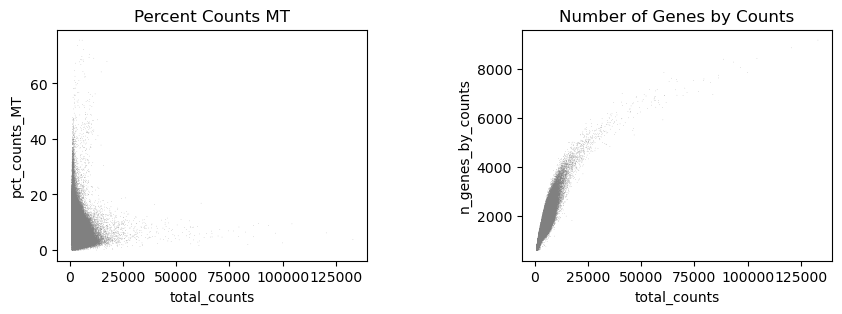

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
plt.subplots_adjust(wspace=0.5)

sc.pl.scatter(adata, "total_counts", "pct_counts_MT", title="Percent Counts MT", ax=axs[0], show=False)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", title="Number of Genes by Counts", ax=axs[1])

Based on this scatter plot, we will use the following thresholds for filtering: 

In [15]:
adata = adata[
    (adata.obs["n_genes_by_counts"] < 4000)
    & (adata.obs["n_genes_by_counts"] > 500)
    & (adata.obs["pct_counts_MT"] < 20)
].copy()

Lastly, set a cutoff of the minimum number of cells a gene must be present in. 

In [16]:
%%time
sc.pp.filter_genes(adata, min_cells=3)

CPU times: user 2.29 s, sys: 868 ms, total: 3.16 s
Wall time: 3.15 s


Compare this to running on the GPU

In [17]:
adata_gpu = adata_gpu[
    (adata_gpu.obs["n_genes_by_counts"] < 4000)
    & (adata_gpu.obs["n_genes_by_counts"] > 500)
    & (adata_gpu.obs["pct_counts_MT"] < 20)
].copy()

In [20]:
%%time
# rsc.pp.filter_genes(adata_gpu, qc_var="n_cells_by_counts", min_count=3)
rsc.pp.filter_genes(adata_gpu, min_counts=3)

filtered out 33816 genes that are detected in less than 3 counts
CPU times: user 2.74 s, sys: 184 ms, total: 2.92 s
Wall time: 3 s


The number of genes is reduced from 61,888 to 28,152. 

In [23]:
rsc.__version__

'0.12.7'

In [21]:
len(adata.var)

28037

The number of cells is reduced from 216,611 to 212,613. 

In [22]:
len(adata.obs)

212613

Here we will save a clean version of this dataset for part 2 of the lab. 

In [24]:
adata_gpu.write("filtered_dataset.h5ad") 

### Normalization

The variance of the count matrix varies wildly between cells, but normalization will correct for this. 

In [25]:
%%time
sc.pp.normalize_total(adata)

CPU times: user 3.84 s, sys: 293 ms, total: 4.13 s
Wall time: 3.06 s


In [26]:
%%time
rsc.pp.normalize_total(adata_gpu)

CPU times: user 4.58 s, sys: 166 ms, total: 4.74 s
Wall time: 5.19 s


Taking the log will compress the scale of the data. 

In [27]:
%%time
sc.pp.log1p(adata) 

CPU times: user 3.84 s, sys: 0 ns, total: 3.84 s
Wall time: 3.84 s


In [28]:
%%time
rsc.pp.log1p(adata_gpu) 

CPU times: user 27 ms, sys: 34.2 ms, total: 61.2 ms
Wall time: 58.9 ms


### Feature selection

In this section we will select for only highly variable genes. 

The function annoates the highly variable genes. 

In [29]:
%%time
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=5000)

CPU times: user 2.45 s, sys: 43.3 ms, total: 2.49 s
Wall time: 124 ms


Using the new `highly_variable` boolean column, subset the dataset to only include these highly variable genes. 

In [30]:
adata = adata[: ,adata.var["highly_variable"]].copy()

In [31]:
%%time
rsc.pp.highly_variable_genes(adata_gpu, flavor="cell_ranger", n_top_genes=5000)

CPU times: user 342 ms, sys: 9.36 ms, total: 351 ms
Wall time: 350 ms


In [32]:
adata_gpu = adata_gpu[: ,adata_gpu.var["highly_variable"]].copy()

Now there are only 5000 genes in the dataset. 

In [33]:
len(adata.var)

5000

## PCA

Even though the number of genes has been reduced from 60k to 5k, that's still far too many features to use for our analysis. To solve this, we will use PCA to reduce the dimensaionlity of the dataset while preserving the variability. 

Scale the data matrix `X` to have unit variance to prepare for PCA. 

In [34]:
%%time
sc.pp.scale(adata, zero_center=False, max_value=10)

CPU times: user 1.49 s, sys: 150 ms, total: 1.64 s
Wall time: 672 ms


In [35]:
%%time
rsc.pp.scale(adata_gpu, zero_center=False, max_value=10)

CPU times: user 257 ms, sys: 5.88 ms, total: 263 ms
Wall time: 261 ms


Run PCA with 50 components. 

In [36]:
%%time
sc.pp.pca(adata, n_comps=50)

CPU times: user 1min 23s, sys: 0 ns, total: 1min 23s
Wall time: 12.7 s


In [37]:
%%time
rsc.pp.pca(adata_gpu, n_comps=50)

CPU times: user 6.02 s, sys: 0 ns, total: 6.02 s
Wall time: 6.11 s


Plot the variance captured by each principal component below: 

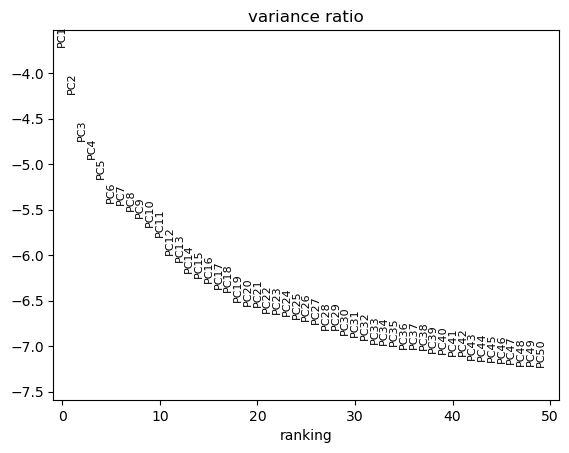

In [38]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

## Clustering

In this section, we will use clustering to identify cellular structures in the dataset. 

In [39]:
import numpy as np

Integrate data from different assays using [Harmony](https://www.nature.com/articles/s41592-019-0619-0). Note the CPU implementation takes around 5 minutes. 

In [ ]:
# %%time
# sc.external.pp.harmony_integrate(adata, key="assay")

# # 2025-02-19 19:43:28,492 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
# # 2025-02-19 19:43:37,897 - harmonypy - INFO - sklearn.KMeans initialization complete.
# # 2025-02-19 19:43:38,725 - harmonypy - INFO - Iteration 1 of 10
# # 2025-02-19 19:44:36,754 - harmonypy - INFO - Iteration 2 of 10
# # 2025-02-19 19:45:35,527 - harmonypy - INFO - Iteration 3 of 10
# # 2025-02-19 19:46:33,537 - harmonypy - INFO - Iteration 4 of 10
# # 2025-02-19 19:47:31,306 - harmonypy - INFO - Iteration 5 of 10
# # 2025-02-19 19:48:02,451 - harmonypy - INFO - Iteration 6 of 10
# # 2025-02-19 19:48:31,017 - harmonypy - INFO - Iteration 7 of 10
# # 2025-02-19 19:48:59,467 - harmonypy - INFO - Converged after 7 iterations
# # CPU times: user 42min 20s, sys: 3h 53min 9s, total: 4h 35min 29s
# # Wall time: 5min 31s

In [40]:
%%time
rsc.pp.harmony_integrate(adata_gpu, key="assay", dtype=np.float32)

CPU times: user 10.4 s, sys: 2.97 s, total: 13.4 s
Wall time: 13.5 s


Generate K-Nearest Neighbors map

In [41]:
%%time
sc.pp.neighbors(adata, n_pcs=50)

CPU times: user 53.8 s, sys: 2.45 s, total: 56.2 s
Wall time: 56 s


In [42]:
%%time
rsc.pp.neighbors(adata_gpu, n_pcs=50)

CPU times: user 3.88 s, sys: 101 ms, total: 3.98 s
Wall time: 3.98 s


Run UMAP

In [ ]:
# %%time
# sc.tl.umap(adata)

# # CPU times: user 15min 40s, sys: 351 ms, total: 15min 41s
# # Wall time: 2min 13s

In [43]:
%%time
rsc.tl.umap(adata_gpu)

CPU times: user 561 ms, sys: 136 ms, total: 696 ms
Wall time: 712 ms


Run [Leiden clustering ](https://www.nature.com/articles/s41598-019-41695-z) to group similar cell types. 

In [ ]:
# %%time
# sc.tl.leiden(adata, resolution=0.5)

# # CPU times: user 2min 23s, sys: 1.9 s, total: 2min 25s
# # Wall time: 2min 25s

In [44]:
%%time
rsc.tl.leiden(adata_gpu, resolution=0.5)

CPU times: user 1.17 s, sys: 1.26 s, total: 2.43 s
Wall time: 2.66 s


Plot the clusters

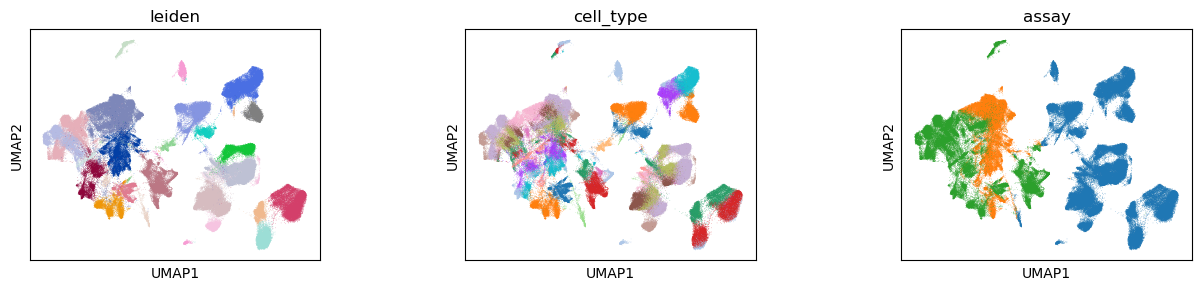

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.5) # space the plots out 

sc.pl.umap(adata_gpu, color=["leiden"], legend_loc="none", ax=axs[0], show=False)
sc.pl.umap(adata_gpu, color=["cell_type"], legend_loc="none", ax=axs[1], show=False)
sc.pl.umap(adata_gpu, color=["assay"], legend_loc="none", ax=axs[2])

### Embedding Density

This section looks at the embedding density for each assay. 

Calculate the embedding density

In [ ]:
# %%time
# sc.tl.embedding_density(adata, groupby="assay")

# # CPU times: user 2min 47s, sys: 0 ns, total: 2min 47s
# # Wall time: 2min 30s

In [46]:
%%time
rsc.tl.embedding_density(adata_gpu, groupby="assay")

CPU times: user 15.1 s, sys: 1.89 s, total: 16.9 s
Wall time: 17.1 s


Plot the embedding density

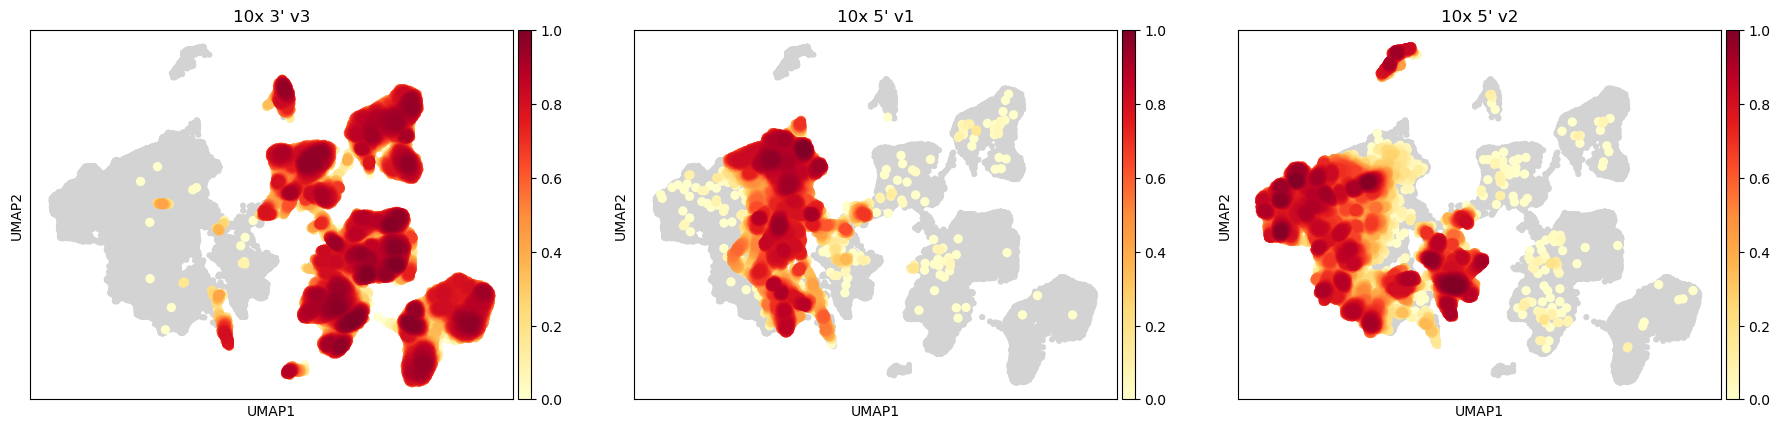

In [47]:
sc.pl.embedding_density(adata_gpu, groupby="assay")

## Conclusion

By loading, exploring, and summarizing both gene and cell metadata, the notebook lays a solid foundation for the lab. It prepares the single‑cell data by verifying its integrity and quality which is essential for interpreting biological signals and for use in further processing steps.

We have also observed the acclelaration achieved by using RAPIDS Single-cell for analyzing and transforming single-cell data.    

**Catatan**:   
Hasil notebook ini **berbeda** dengan hasil notebook di GPU NVIDIA Cloud. 

Now **shut down the kernel** so this notebook stops using memory. 

In [ ]:
# DO NOT CHANGE THIS CELL
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(False)

**Note**: Executing the provided code cell will shut down the kernel and activate a popup indicating that the kernel has restarted.

**Well Done!** Let's move to the [next notebook](02_Label_Transfer.ipynb). 

<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">